In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import networkx as nx
from scipy.special import softmax
from tqdm import tqdm
from random import shuffle
import copy
from collections import defaultdict
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from uga import UGA,UGA_RSL
from trm import TRM
from lp import LP
from local_ratio import Local_Ratio
from hs import HS,RSL
data = pd.read_csv('nyc_citi.csv')
data = data.loc[[type(i)==str for i in data['start station name']]]
data = data.loc[[type(i)==str for i in data['end station name']]]
data.starttime=data.starttime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data.stoptime=data.stoptime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [2]:
def build_station_graph(data,starttime,stoptime):
    graphx=nx.Graph()
    filtered_data = data[(data['starttime']>=starttime) & (data['stoptime']<=stoptime)]
    locations = list(set(filtered_data['start station name']).union(filtered_data['end station name']))
    vertices = pd.Series([{}]*len(locations),index=locations)
    for loc in locations:
        vertices[loc] = {'change':0,'x':np.random.random(),'y':np.random.random(),'type':''}
        
    for i in filtered_data['start station name']:
        vertices[i]['change'] -= 1
    for i in filtered_data['end station name']:
        vertices[i]['change'] += 1
    for loc in locations:
        if vertices[loc]['change'] > 0:
            vertices[loc]['type'] = 'overflow'
        if vertices[loc]['change'] < 0:
            vertices[loc]['type'] = 'underflow'
    vertices = vertices.loc[[x['type'] != '' for x in vertices]]
    for vertex in vertices.index:
        graphx.add_node(vertex,bipartite=int(vertices[vertex]['type']=='overflow'))
    #print(vertices)
    nx.set_node_attributes(graphx, {i: vertices[i] for i in vertices.index}) 
    for i in range(len(vertices.index)):
        for j in range(len(vertices.index)):
            if vertices[vertices.index[i]]['type'] != vertices[vertices.index[j]]['type'] and not graphx.has_edge(i,j):
                x1=vertices[vertices.index[i]]['x']
                y1=vertices[vertices.index[i]]['y']
                x2=vertices[vertices.index[j]]['x']
                y2=vertices[vertices.index[j]]['y']
                graphx.add_weighted_edges_from([(vertices.index[i],vertices.index[j],euc_dis(x1,y1,x2,y2))])
    return graphx

def cloned_station_vertices(graphx):
    nodes = list(graphx.nodes())
    for node in nodes:
        if graphx.nodes[node]['change']>1:
            for i in range(graphx.nodes[node]['change']-1):
                i = i+1
                graphx.add_nodes_from([(str(node)+str(i),graphx.nodes[node])],bipartite=int(graphx.nodes[node]['bipartite']))
                new_node_name = str(node)+str(i)
                new_node_data = graphx.nodes[new_node_name]
                for node_ in graphx.nodes:
                    if new_node_data['bipartite'] != graphx.nodes[node_]['bipartite']:
                        x1=new_node_data['x']
                        y1=new_node_data['y']
                        x2=graphx.nodes[node_]['x']
                        y2=graphx.nodes[node_]['y']
                        graphx.add_weighted_edges_from([(node_,new_node_name,euc_dis(x1,y1,x2,y2))])
    return graphx
                
def draw_bipartite(B):
    l, r = nx.bipartite.sets(B)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(B, pos=pos)
    plt.show()
def draw_graph(B):
    pos = {}

    # Update position for node from each group
    pos.update((node, (B.nodes[node]['x'], B.nodes[node]['y'])) for node in list(B.nodes))
    nx.draw(B, pos=pos)
    plt.show()
                
def euc_dis(x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**.5         

['W 20 St & 8 Ave', 'W 20 St & 7 Ave', 'W 45 St & 6 Ave (1)', 'Pearl St & Anchorage Pl', 'NYCBS Depot - DEL', 'Allen St & Stanton St', 'Washington Square E', 'W 54 St & 9 Ave', 'Mercer St & Spring St', 'Rivington St & Chrystie St', '11 Ave & W 41 St', 'E 4 St & 2 Ave', 'West St & Chambers St', '8 Ave & W 31 St N', '8 Ave & W 33 St', 'Ashland Pl & Hanson Pl', 'W 37 St & 10 Ave', 'Stanton St & Chrystie St', 'W 13 St & 6 Ave', 'E 6 St & Avenue B', 'Pershing Square North', '6 Ave & W 33 St', 'Bayard St & Baxter St', 'W 22 St & 8 Ave', 'Forsyth St & Broome St', 'University Pl & E 14 St', 'W 47 St & 10 Ave', 'Broadway & W 24 St', '10 Ave & W 28 St', 'Fulton St & Grand Ave', 'Hancock St & Bedford Ave', 'W 52 St & 11 Ave', 'W 29 St & 9 Ave', 'Division St & Bowery', 'Broadway & W 58 St', 'W 33 St & 7 Ave', 'Broadway & E 14 St', '2 Ave & E 31 St', 'Warren St & Church St', '6 Ave & Broome St', 'E 31 St & 3 Ave', 'Henry St & Grand St', 'Clermont Ave & Lafayette Ave', 'W 15 St & 7 Ave', 'Murray St 

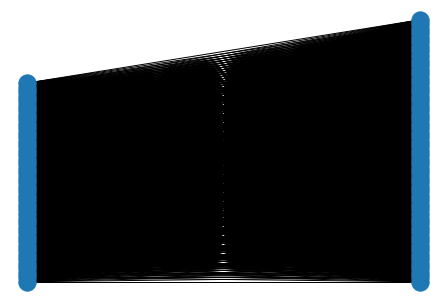

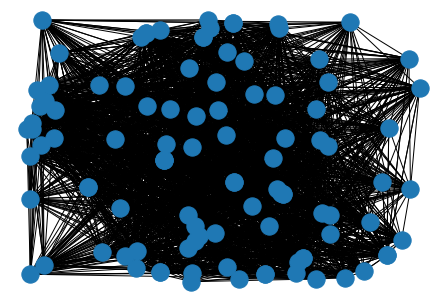

In [3]:

graph = build_station_graph(data,data.loc[0,'starttime'],data.loc[100,'stoptime'])
#print(graph['E 6 St & Avenue D'])
overflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='overflow'}
underflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='underflow'}


cgraph = cloned_station_vertices(graph)
workers = {str(i):{
                'type':'worker',
               'xs':np.random.random(),
               'ys':np.random.random(),
               'xe':np.random.random(),
               'ye':np.random.random()
              } for i in range(np.min([len(underflow), len(overflow)]))}
cwgraph = copy.deepcopy(cgraph)
print(cwgraph.nodes)
cwgraph.add_nodes_from(workers.keys())
nx.set_node_attributes(cwgraph, workers) 
cwgraph.add_edges_from([(w,s) for w in workers for s in cgraph.nodes])
worker = {node:{} for node in cwgraph.nodes() if cwgraph.nodes[node]['type']=='worker'}
print(cwgraph.nodes)

In [ ]:
uga = UGA(cwgraph)
best, score, log = uga.run(0.1,0.1,40,20)
plt.plot(log)
plt.show()
best

In [ ]:
trm = TRM()
trm.solve(cgraph,cwgraph,worker)[-1]

In [ ]:
lp_ = LP()
m,s =lp_.solve(cwgraph,worker,overflow,underflow)
s

In [ ]:
lr = Local_Ratio()
lr.solve(cwgraph)[1]

In [ ]:
rsl = RSL()
rsl.optimize(cwgraph)

100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


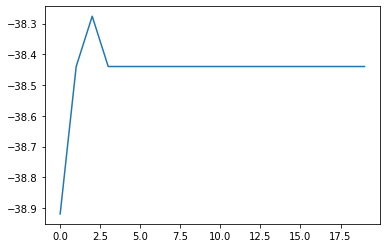

-38.2759868593761

In [5]:
uga2 = UGA_RSL(cwgraph)
graph,best,log = uga2.run(0.1,20,5)
plt.plot(log)
plt.show()
best